In [10]:
from __future__ import division
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy as scp
import pylab as pyl

import warnings
warnings.filterwarnings('ignore')
np.random.seed(1234)

%matplotlib inline
%load_ext autoreload                                                                                                                                                                                                
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
if not os.path.isdir('DampedNewtonlogexpstabilizationtests_images'):
    os.makedirs('DampedNewtonlogexpstabilizationtests_images')

In [13]:
"""To compute distance matrix"""
def distmat(x,y):
    return np.sum( x**2,0 )[:,None] + np.sum( y**2,0 )[None,:] - 2*x.transpose().dot(y)

"""To Normalise a vector"""
normalize = lambda a: a/np.sum( a )

"""To Compute P"""
def GetP(u,K,v):
    u = u.reshape(u.shape[0],)
    v = v.reshape(v.shape[0],)
    return u[:,None]*K*v[None,:]

def plotp(x, col,plt, scale=200, edgecolors="k"):
  return plt.scatter( x[0,:], x[1,:], s=scale, edgecolors=edgecolors,  c=col, cmap='plasma', linewidths=2 )

In [14]:
def generate_data(N):
    """
     N is a list of the size of the data on x and y
    """
    x = np.random.rand( 2,N[0] )-0.5
    theta = 2*np.pi*np.random.rand( 1,N[1] )
    r = 0.8+.2*np.random.rand( 1,N[1] )
    y = np.vstack( ( r*np.cos( theta ),r*np.sin( theta ) ) )
    return x,y


In [15]:
N = [ 1000,1500 ]
x,y = generate_data(N)

In [16]:
import computational_OT

In [17]:
epsilons = [ 1.0, 0.5, 0.3, 0.1, 0.09, 0.05, 0.03,0.02,0.01, 0.001 ]


## Sinkhorn

In [9]:
# Sinkhorn
print("Sinkhorn.... ")
SinkhornP = []
results_Sinkhorn = []
times_Sinkhorn = []
Pmatrix_dist_linVSsinkhorn = []
for eps in epsilons:

  
  #Cost matrix
  C = distmat(x,y)
  
  # a and b
  a = normalize(np.ones(N[0]))
  a = a.reshape(a.shape[0],-1)
  b = normalize(np.ones(N[1]))
  b = b.reshape(b.shape[0],-1)



  #Kernel
  K = np.exp(-C/eps)


  print( "Doing for (",N[0],N[1],")." )
  print( " |- Iterating" )

  #Inflating
  u = a
  v = b

  start = time.time()
  Optimizer = computational_OT.Sinkhorn( K,a,b,u,v,eps)
  out = Optimizer._update(maxiter=10000)
  results_Sinkhorn.append( out )
  end = time.time()
  times_Sinkhorn.append(1e-3*(end-start) )
  print( " |- Computing P" )
  print( "" )
  SinkhornP.append( GetP( out['u'],K,out['v'] ) )
  

Sinkhorn.... 
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  11
 |- Computing P

Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  19
 |- Computing P

Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  33
 |- Computing P

Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  108
 |- Computing P

Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  120
 |- Computing P

Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  222
 |- Computing P

Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  378
 |- Computing P

Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  576
 |- Computing P

Doing for ( 1000 1500 ).
 |- Iterating


KeyboardInterrupt: 

In [ ]:
plt.figure( figsize = (20,7) )

plt.subplot(2,1,1),
plt.title( "$||P1 -a||_1+||P1 -b||_1$" )
for i in range( len(results_Sinkhorn) ):
  error=np.asarray( results_Sinkhorn[i]['error_a'] )+np.asarray( results_Sinkhorn[i]['error_b'] )
  plt.plot( error,label = 'Sinkhorn for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )
plt.yscale( 'log' )
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error in log-scale")

plt.savefig("DampedNewtonlogexpstabilizationtests_images/ConvergenceSinkhornvaryingepsilon.png")
plt.show()

## Damped Newton with log-exp stabilization

In [ ]:
rho = 0.95
c = 0.05
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []
Hessians_DampedNewton = []

#epsilons=[0.05,0.08,0.1]

noise = [0,0,0,0,0,0,0,1e-8,1e-8,1e-4]
# epsilons=[0.02]
for eps in range(len(epsilons)):
    
    # Line Search
    print( "Damped Newton for epsilon = "+str(epsilons[eps])+":" )    
    #Cost matrix
    C = distmat(x,y)

    # a and b
    a = normalize( np.ones( N[0] ) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones( N[1] ) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/epsilons[eps])
    f,g = a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewtonLogexp( K,a,b,f,g,epsilons[eps],rho,c )
    out = Optimizer._update( stabilize = 1, stabilization_noise = noise[eps], maxiter = 50 )
    results_DampedNewton.append( out )
    end = time.time()
    times_DampedNewton.append( 1e-3*(end-start) )
    print( " |- Computing P" )
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/epsilons[eps]),K,np.exp(out['potential_g']/epsilons[eps])) )
    print( " |- Recording (unstabilized) Hessian \n" )

    mat  = -epsilons[eps]*Optimizer.Hessian
    diag = 1/np.sqrt( np.vstack( (a,b) ) ).flatten()
    mat = diag[:,None]*mat*diag[None,:]
    Hessians_DampedNewton.append( mat )


In [ ]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "$||P1 -a||_1+||P^T 1 -b||_1$" )

for i in range(len(results_DampedNewton)):
  error = np.asarray( results_DampedNewton[i]['error_a'] )+np.asarray( results_DampedNewton[i]['error_b'] )
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Error in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.savefig( "DampedNewtonlogexpstabilizationtests_images/ErrorDampedNewton.png" )
plt.show()
print( "\n Error plots can increase! The error is not the objective function!" )

In [ ]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )

plt.title( "Objective Function" )
for i in range(len(results_DampedNewton)):
  plt.plot( np.asarray( results_DampedNewton[i]["objectives"] ),label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Objective value" )
plt.legend()
plt.savefig("DampedNewtonlogexpstabilizationtests_images/ObjectiveDampedNewton.png")
plt.show()


In [ ]:
plt.figure( figsize = (20,7) )
plt.subplot(2,1,1),
plt.title( "Alpha" )

for i in range(len(results_DampedNewton)):
  plt.plot( np.asarray( results_DampedNewton[i]['linesearch_steps'] ),label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )

plt.xlabel( "Number of iterations" )
plt.ylabel( "Alpha in log-scale" )
plt.legend()
# plt.yscale( 'log')
plt.savefig("DampedNewtonlogexpstabilizationtests_images/AlphaDampedNewton.png")
plt.show()

### Time plot of Sinkhorn vs Damped Newton

In [ ]:
plt.figure( figsize = (20,7) )

plt.subplot(2,1,1),
plt.title( "Time Plot" )
plt.plot( epsilons,times_Sinkhorn, linewidth = 2,marker = 'o' )
plt.plot( epsilons,times_DampedNewton, linewidth = 2,marker = 'o'  )


plt.legend(['Sinkhorn Time','Damped Newton Time'])
plt.xlabel("$\epsilon$")
plt.ylabel("Time in ms")

plt.savefig("DampedNewtonlogexpstabilizationtests_images/Timeplot_SinkhornvsDampedNewton.png")
plt.show()

In [ ]:
def spectral_decomposition(mat):
    eig, v = np.linalg.eigh( mat )
    sorting_indices = np.argsort(eig)
    eig = eig[sorting_indices]
    v   = v[:, sorting_indices]
    
    print( "List of smallest eigenvalues: ", eig[:10])
    print( "List of largest  eigenvalues: ", eig[-10:])

    return eig,v

In [ ]:
eigs = []
eigvecs = []
for i in range( len(epsilons) ) :
    eps = epsilons[i]
    print( "Spectral statistics of Hessian for epsilon="+str(eps) )
    ev = spectral_decomposition( Hessians_DampedNewton[i] )
    eigs.append( ev[0] )
    eigvecs.append( ev[1] )
    print("")


In [ ]:
fig,ax = plt.subplots( figsize=(30,3),nrows=1, ncols=len(epsilons), sharey=True )
plt.title( "Histogram of eigenvalues." )
for i in range( len(epsilons) ):
    ax[i].hist( eigs[i], 50 )
    ax[i].set_title( " $\epsilon$: "+str(epsilons[i]) )
    ax[i].set_xlabel( "Eigenvalues" )
    ax[i].set_yscale( "log" )
plt.subplots_adjust( wspace=0,hspace=0 )
plt.savefig("DampedNewtonlogexpstabilizationtests_images/eigenhistunstabilized.png")
plt.show()

## Compare Damped Newton with or without stabilization

### Without Stabilization

In [18]:
rho = 0.95
c = 0.05
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []
Hessians_DampedNewton = []

#epsilons=[0.05,0.08,0.1]
epsilons = [1.0, 0.5, 0.3, 0.1, 0.09, 0.05, 0.03]

noise = [0,0,0,0,0,0,0,1e-8,1e-8,1e-4]
# epsilons=[0.02]
for eps in range(len(epsilons)):
    
    # Line Search
    print( "Damped Newton for epsilon = "+str(epsilons[eps])+":" )    
    #Cost matrix
    C = distmat(x,y)

    # a and b
    a = normalize( np.ones( N[0] ) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones( N[1] ) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/epsilons[eps])
    f,g = a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewtonLogexp( K,a,b,f,g,epsilons[eps],rho,c )
    out = Optimizer._update( stabilize = 0, stabilization_noise = noise[eps], maxiter = 50 )
    results_DampedNewton.append( out )
    end = time.time()
    times_DampedNewton.append( 1e-3*(end-start) )
    print( " |- Computing P" )
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/epsilons[eps]),K,np.exp(out['potential_g']/epsilons[eps])) )
    print( " |- Recording (unstabilized) Hessian \n" )

    mat  = -epsilons[eps]*Optimizer.Hessian
    diag = 1/np.sqrt( np.vstack( (a,b) ) ).flatten()
    mat = diag[:,None]*mat*diag[None,:]
    Hessians_DampedNewton.append( mat )


Damped Newton for epsilon = 1.0:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  18
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.5:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  17
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.3:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  17
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.1:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  16
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.09:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  16
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.05:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  16
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.03:
Doin

In [19]:
f1, g1 = [], []
for i in range(len(results_DampedNewton)):
    f1.append(results_DampedNewton[i]['potential_f'])
    g1.append(results_DampedNewton[i]['potential_g'])

### with exp-log stabilization

In [20]:
rho = 0.95
c = 0.05
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []
Hessians_DampedNewton = []

#epsilons=[0.05,0.08,0.1]
epsilons = [1.0, 0.5, 0.3, 0.1, 0.09, 0.05, 0.03]

noise = [0,0,0,0,0,0,0]
# epsilons=[0.02]
for eps in range(len(epsilons)):
    
    # Line Search
    print( "Damped Newton for epsilon = "+str(epsilons[eps])+":" )    
    #Cost matrix
    C = distmat(x,y)

    # a and b
    a = normalize( np.ones( N[0] ) )
    a = a.reshape( a.shape[0],-1 )
    b = normalize( np.ones( N[1] ) )
    b = b.reshape( b.shape[0],-1 )

    #Kernel
    K = np.exp(-C/epsilons[eps])
    f,g = a,b

    print( "Doing for (",N[0],N[1],")." )
    print( " |- Iterating" )  
    start = time.time()
    Optimizer = computational_OT.DampedNewtonLogexp( K,a,b,f,g,epsilons[eps],rho,c )
    out = Optimizer._update( stabilize = 1, stabilization_noise = noise[eps], maxiter = 50 )
    results_DampedNewton.append( out )
    end = time.time()
    times_DampedNewton.append( 1e-3*(end-start) )
    print( " |- Computing P" )
    DampedNewtonP.append( GetP(np.exp(out['potential_f']/epsilons[eps]),K,np.exp(out['potential_g']/epsilons[eps])) )
    print( " |- Recording (unstabilized) Hessian \n" )

    mat  = -epsilons[eps]*Optimizer.Hessian
    diag = 1/np.sqrt( np.vstack( (a,b) ) ).flatten()
    mat = diag[:,None]*mat*diag[None,:]
    Hessians_DampedNewton.append( mat )


Damped Newton for epsilon = 1.0:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  18
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.5:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  17
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.3:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  17
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.1:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  16
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.09:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  16
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.05:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  16
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon = 0.03:
Doin

In [21]:
f2, g2 = [], []
for i in range(len(results_DampedNewton)):
    f2.append(results_DampedNewton[i]['potential_f'])
    g2.append(results_DampedNewton[i]['potential_g'])

#### Difference plot for potential from Damped Newton

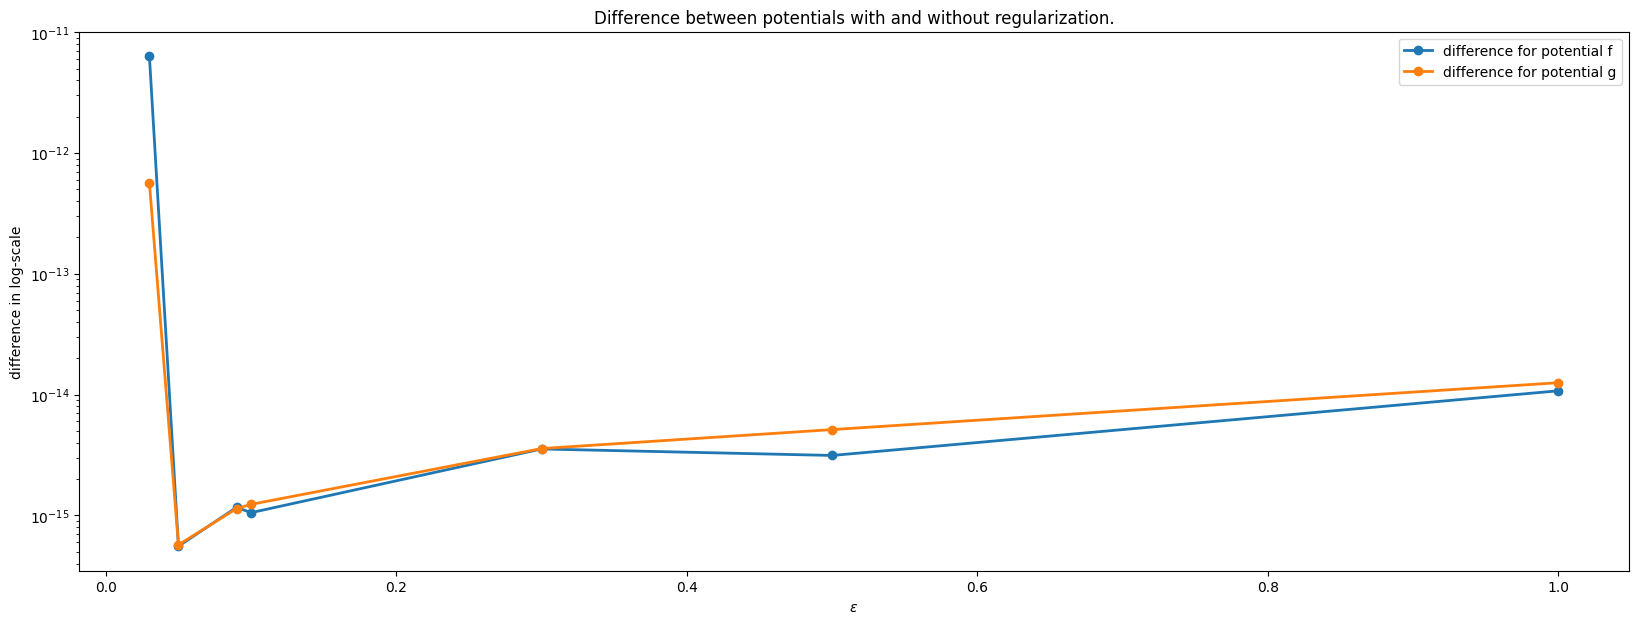

In [22]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "Difference between potentials with and without regularization." )
difference_f = [np.linalg.norm(f1[i]-f2[i]) for i in range(len(results_DampedNewton)) ]
difference_g = [np.linalg.norm(g1[i]-g2[i]) for i in range(len(results_DampedNewton)) ]
plt.plot(epsilons, difference_f, label = 'difference for potential f', linewidth = 2, marker= 'o' )
plt.plot(epsilons, difference_g, label = 'difference for potential g', linewidth = 2, marker= 'o' )




plt.xlabel("$\epsilon$")
plt.ylabel( "difference in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.show()

## Compare Sinkhorn with or without stabilization

### Without Stabilization

In [ ]:
# Sinkhorn
print("Sinkhorn.... ")
SinkhornP = []
results_Sinkhorn = []
times_Sinkhorn = []
Pmatrix_dist_linVSsinkhorn = []
epsilons = [1.0, 0.5, 0.3, 0.1, 0.09, 0.05, 0.03, 0.02,0.001]

for eps in epsilons:

  print( "Sinkhorn for epsilon = "+str(eps)+":" )    

  #Cost matrix
  C = distmat(x,y)
  
  # a and b
  a = normalize(np.ones(N[0]))
  a = a.reshape(a.shape[0],-1)
  b = normalize(np.ones(N[1]))
  b = b.reshape(b.shape[0],-1)



  #Kernel
  K = np.exp(-C/eps)


  print( "Doing for (",N[0],N[1],")." )
  print( " |- Iterating" )

  #Inflating
  u = a
  v = b

  start = time.time()
  Optimizer = computational_OT.Sinkhorn( K,a,b,u,v,eps)
  out = Optimizer._update(maxiter=1000)
  results_Sinkhorn.append( out )
  end = time.time()
  times_Sinkhorn.append(1e-3*(end-start) )
  print( " |- Computing P" )
  print( "" )
  SinkhornP.append( GetP( out['u'],K,out['v'] ) )
  

Sinkhorn.... 
Sinkhorn for epsilon = 1.0:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  11
 |- Computing P

Sinkhorn for epsilon = 0.5:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  19
 |- Computing P

Sinkhorn for epsilon = 0.3:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  33
 |- Computing P

Sinkhorn for epsilon = 0.1:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  108
 |- Computing P

Sinkhorn for epsilon = 0.09:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  120
 |- Computing P

Sinkhorn for epsilon = 0.05:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  222
 |- Computing P

Sinkhorn for epsilon = 0.03:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  378
 |- Computing P

Sinkhorn for epsilon = 0.02:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  576
 |- Computing P

Sinkhorn for epsilon = 0.001:
Doing for (

In [ ]:
u1, v1 = [], []
for i in range(len(results_Sinkhorn)):
    u1.append(results_Sinkhorn[i]['u'])
    v1.append(results_Sinkhorn[i]['v'])
    
    

### with log-domain sinkhorn








In [ ]:
def mina_u(H,epsilon): 
    return -epsilon*np.log( np.sum(a[:,None] * np.exp(-H/epsilon),0) )
def minb_u(H,epsilon):
    return -epsilon*np.log( np.sum(b[None,:] * np.exp(-H/epsilon),1) )

def mina(H,epsilon): return mina_u(H-np.min(H,0),epsilon) + np.min(H,0);
def minb(H,epsilon): return minb_u(H-np.min(H,1)[:,None],epsilon) + np.min(H,1);


In [ ]:
def log_sinkhorn(a,b, C,epsilon,f, tol = 1e-12, niter = 500):    
    f_list = []
    g_list = []
    P_list = []
    Err = np.zeros(niter)
    for it in range(niter):
        g = mina(C-f[:,None],epsilon)
        f = minb(C-g[None,:],epsilon)
        # generate the coupling
        P = a[:,None] * np.exp((f[:,None]+g[None,:]-C)/epsilon) * b[None,:]
        f_list.append(f)
        g_list.append(g)
        P_list.append(P)
        # check conservation of mass
        Err[it] = np.linalg.norm(np.sum(P,0)-b,1)
        if Err[it] < tol:
            print("Terminating after iteration: ",i+1)
            break
    return (P_list,Err,f_list,g_list)

In [ ]:
# Sinkhorn
print("Sinkhorn.... ")
results_logSinkhorn = []
times_logSinkhorn = []
epsilons = [1.0, 0.5, 0.3, 0.1, 0.09, 0.05, 0.03, 0.02,0.001]

for eps in epsilons:

  print( "Sinkhorn for epsilon = "+str(eps)+":" )    
  
  #Cost matrix
  C = distmat(x,y)
  
  # a and b
  a = normalize(np.ones(N[0]))
  b = normalize(np.ones(N[1]))

  





  print( "Doing for (",N[0],N[1],")." )
  print( " |- Iterating" )

 
  start = time.time()
  output = log_sinkhorn( a,b, C, eps, a, niter = 1000 )
  results_logSinkhorn.append( output )
  end = time.time()
  times_logSinkhorn.append(1e-3*(end-start) )

  

Sinkhorn.... 
Sinkhorn for epsilon = 1.0:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  9
Sinkhorn for epsilon = 0.5:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  9
Sinkhorn for epsilon = 0.3:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  9
Sinkhorn for epsilon = 0.1:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  9
Sinkhorn for epsilon = 0.09:
Doing for ( 1000 1500 ).
 |- Iterating
Terminating after iteration:  9
Sinkhorn for epsilon = 0.05:
Doing for ( 1000 1500 ).
 |- Iterating


In [ ]:
u2, v2 = [], []
for i in range(len(results_Sinkhorn)):
    u2.append(results_Sinkhorn[i]['u'])
    v2.append(results_Sinkhorn[i]['v'])

In [ ]:
plt.figure( figsize = (20,7) )
plt.title( "$$" )
plt.title( "Difference between u and v with and without regularization." )
difference_u = [np.linalg.norm(u1[i]-u2[i]) for i in range(len(results_DampedNewton)) ]
difference_v = [np.linalg.norm(v1[i]-v2[i]) for i in range(len(results_DampedNewton)) ]
plt.plot(epsilons, difference_u, label = 'difference for u', linewidth = 2, marker= 'o' )
plt.plot(epsilons, difference_v, label = 'difference for v', linewidth = 2, marker= 'o' )




plt.xlabel("$\epsilon$")
plt.ylabel( "difference in log-scale" )
plt.legend()
plt.yscale( 'log' )
plt.show()